In [1]:
%matplotlib inline
import numpy as np, pandas as pd, re, matplotlib.pyplot as plt, seaborn as sns, nltk, string
import warnings, itertools
warnings.filterwarnings('ignore', category=DeprecationWarning)
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
from utils import *

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Flatten, Bidirectional, TimeDistributed
import keras
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


In [2]:
# create function to plot of the history
def plot_hist(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(x, acc, 'b', label='Training accuracy')
    plt.plot(x, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation accuracy')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Train and Validation Loss')
    plt.legend()

In [4]:
# function to parse tweets
def clean_content(tweets):
        
    ''' script to parse out punctuation, numbers, special chars, short words repeated letters, white spaces, @handles and urls'''
    
    # create new Series, remove @user reference
    combine['clean_content'] = combine['content'].apply(lambda x: re.sub(r'@\w+', ' ',x))
    # remove rt| cc
    combine['clean_content'] = combine['clean_content'].apply(lambda x: re.sub('rt|cc', ' ',x))
    # remove url related info, replace with URL
    combine['clean_content'] = combine['clean_content'].apply(lambda x: re.sub(r'((www\.[\S]+)|(https?://[\S]+))', 'URL',x))
    # remove punctuation 
    combine['clean_content'] = combine['clean_content'].apply(lambda x: re.sub('[^a-zA-Z]', ' ',x))
    combine['clean_content'] = combine['clean_content'].apply(lambda x: re.sub('[#]', ' ',x))
    # remove repeating letters, i.e funnnny => funny
    combine['clean_content'] = combine['clean_content'].apply(lambda x: re.sub(r'(.)\1+', r'\1\1', x))
    # remove white spaces
    combine['clean_content'] = combine['clean_content'].apply(lambda x: re.sub('  ', ' ', x))
    # remove short words 
    combine['clean_content'] = combine['clean_content'].apply(lambda x: ' '.join([t for t in x.split() if len(t)>3]))
    
    tokenized_twt = combine['clean_content'].apply(lambda x: x.split())
    stemmer = PorterStemmer()
    tokenized_twt = tokenized_twt.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming function
    # put tokens back together
    for i in range(len(tokenized_twt)):
        tokenized_twt[i] = ' '.join(tokenized_twt[i])

    combine['clean_content'] = tokenized_twt
    
    return tweets


In [5]:
# function to return accuracy of the evaluation dataset
def lstm_accuracy(y_orig,y_hat):
    count =0
    for i in range(len(y_orig)):
        if y_orig[i] == y_hat[i]:
            count += 1
        count
    return count/prediction.shape[0]

In [6]:
# load datasets
train = pd.read_csv('/Users/mathewlong/Downloads/data scientist exercise/data/train.csv', encoding='utf-8')
evaluate = pd.read_csv('/Users/mathewlong/Downloads/data scientist exercise/data/evaluate.csv',encoding='utf-8')

# merge documents and preprocess together, separate back to train/evaluate sets after
combine = train.append(evaluate, ignore_index=True).apply(lambda x: x.astype(str).str.lower())
combine.head()

,content,sentiment
0,rt @evixy_: @havocharb 🙄 all right sherlock. e...,negative
1,@honeybeemtb @80sbuttplug @cnn @zbyronwolf so ...,neutral
2,#beer. #grub. #stadiumseating. best place in ...,neutral
3,i want thissssssssss 😍😍😍😍😍 u have a perfect pl...,positive
4,youtu.be/d2ihy4erdas if you drink diet soda or...,neutral


In [7]:
combine = clean_content(combine)
combine.head(3)

,content,sentiment,clean_content
0,rt @evixy_: @havocharb 🙄 all right sherlock. e...,negative,right sherlock shit
1,@honeybeemtb @80sbuttplug @cnn @zbyronwolf so ...,neutral,your say will rape ironi didn call mexican rap...
2,#beer. #grub. #stadiumseating. best place in ...,neutral,beer grub stadiums best place town watch bigga...


In [8]:
# create sentiment dictionary and label feature
sentiment_dic = {'positive':1, 'neutral': 0, 'negative':-1 }
combine['sentiment_label'] = combine['sentiment'].map(sentiment_dic)
combine.head(1)

,content,sentiment,clean_content,sentiment_label
0,rt @evixy_: @havocharb 🙄 all right sherlock. e...,negative,right sherlock shit,-1


In [9]:
# separate data back to train and evaluate sets
train = combine.iloc[:160000,-2:]
evaluate = combine.iloc[160000:,-2:]

# print(train.shape, evaluate.shape)
# print(train.head())

In [10]:
#extract values from the dataframe objects
y = train['sentiment_label'].values
sentences = train['clean_content'].values

y_rnn = keras.utils.to_categorical(y, num_classes=3)

# find the max number of words in sentences
combine['token_length'] = [len(x.split(' ')) for x in combine.clean_content]
maxlen = max(combine.token_length)
print(maxlen)

# split of strings of text into individual tokens
tokenizer = Tokenizer(num_words=12000, oov_token = True)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

vocab_size = len(tokenizer.word_index) + 1

# set vectors to process in the network
X_pad = pad_sequences(sequences,padding='post', maxlen=40)

#split into train and validation set for rnn
X_train_seq, X_val_seq, y_trainRNN, y_valRNN = train_test_split(X_pad, y_rnn, random_state=44, test_size=0.2)
X_train_seq, X_val_seq, y_train, y_val = train_test_split(X_pad, y, random_state=44, test_size=0.2)

# Oversampling, increasing # of sample points with the norm
smote = SMOTE(ratio='auto', n_jobs=-1)
X_smote,y_smote = smote.fit_sample(X_train_seq, y_train)

y_trainRNN = keras.utils.to_categorical(y_smote, num_classes=3)
y_valRNN = keras.utils.to_categorical(y_val, num_classes=3)


39


In [11]:
# confirm correct dimensions
print(X_train_seq.shape, X_val_seq.shape, y_train.shape, y_val.shape)

(128000, 40) (32000, 40) (128000,) (32000,)


In [12]:
# define FeedForward baseline model
def baseline_model():
    
    model = Sequential()
    model.add(Dense(128, input_dim=40, activation='relu'))
    model.add(Dense(128))
    model.add(Dense(3, activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [37]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold, cross_val_score

estimator = KerasClassifier(build_fn=baseline_model, epochs=5, batch_size=128, verbose=0)

In [38]:
base_model = baseline_model()

FF_preds = base_model.predict(X_val_seq)
# predFF[:2]

In [39]:
seed = 7
np.random.seed(seed)
kfold = KFold(n_splits=5, shuffle=False, random_state=seed)
results = cross_val_score(estimator, X_train_seq, y_train, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


Baseline: 39.90% (4.65%)


Accuracy for tweet sentiment with Logistic Regression: 44.306%
Accuracy for tweet sentiment with Naive Bayes: 41.794%


Text(27.599999999999998, 0.5, 'predicted label')

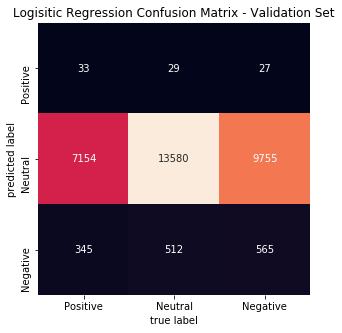

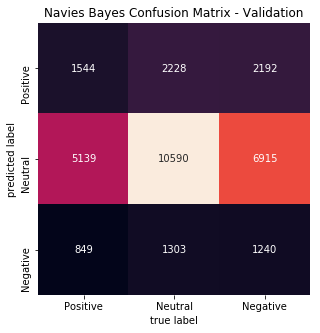

In [16]:
# Compare LogisticRegression and Naive Bayes model performance

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# Establish additional baseline models, fit the models on train set, evaluate on validation set
# build logistic regression model
classifier = LogisticRegression()
classifier.fit(X_train_seq, y_train)
lr_score = classifier.score(X_val_seq, y_val)
lr_yhat_val = classifier.predict(X_val_seq)
print('Accuracy for tweet sentiment with Logistic Regression: {:.3f}%'.format(lr_score*100))

# plot confusion matrix
plt.figure(1, figsize=(5,5))
cm = confusion_matrix(y_val, lr_yhat_val)
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=['Positive', 'Neutral', 'Negative'], yticklabels=['Positive', 'Neutral', 'Negative'])
plt.title('Logisitic Regression Confusion Matrix - Validation Set')
plt.xlabel('true label')
plt.ylabel('predicted label')

# Build Naive Bayes Model
model = MultinomialNB()
model.fit(X_train_seq, y_train)
bayes_score = model.score(X_val_seq, y_val)
bayes_yhat_val = model.predict(X_val_seq)
print('Accuracy for tweet sentiment with Naive Bayes: {:.3f}%'.format(bayes_score*100))

# plot confusion matrix
plt.figure(2, figsize=(5,5))
cm = confusion_matrix(y_val, bayes_yhat_val)
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=['Positive', 'Neutral', 'Negative'], yticklabels=['Positive', 'Neutral', 'Negative'])
plt.title('Navies Bayes Confusion Matrix - Validation')
plt.xlabel('true label')
plt.ylabel('predicted label')

In [32]:
# define LSTM model
from keras.layers.normalization import BatchNormalization

vocab_size = 12000
embedding_size = 50
maxlen = 40

model = Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=40))
model.add(Bidirectional(LSTM(128, dropout=0.5, activation='relu',return_sequences=True)))
model.add(BatchNormalization())
model.add(TimeDistributed(Dense(50, activation='relu')))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))

optimizer = Adam(lr=0.0001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [33]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 40, 50)            600000    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 40, 256)           183296    
_________________________________________________________________
batch_normalization_6 (Batch (None, 40, 256)           1024      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 40, 50)            12850     
_________________________________________________________________
flatten_5 (Flatten)          (None, 2000)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 3)                 6003      
Total params: 803,173
Trainable params: 802,661
Non-trainable params: 512
_________________________________________________________________
No

Train on 170637 samples, validate on 32000 samples
Epoch 1/10
170637/170637 [==============================] - 300s 2ms/step - loss: 0.6756 - acc: 0.7187 - val_loss: 4.7443 - val_acc: 0.3233
Epoch 2/10
170637/170637 [==============================] - 341s 2ms/step - loss: 0.4987 - acc: 0.8424 - val_loss: 3.9526 - val_acc: 0.3233
Epoch 3/10
170637/170637 [==============================] - 328s 2ms/step - loss: 0.4778 - acc: 0.8498 - val_loss: 3.1780 - val_acc: 0.3233
Epoch 4/10
170637/170637 [==============================] - 319s 2ms/step - loss: 0.4669 - acc: 0.8541 - val_loss: 3.7476 - val_acc: 0.3233
Epoch 5/10
170637/170637 [==============================] - 329s 2ms/step - loss: 0.4421 - acc: 0.8592 - val_loss: 3.3342 - val_acc: 0.3233
Epoch 6/10
170637/170637 [==============================] - 348s 2ms/step - loss: 0.4371 - acc: 0.8633 - val_loss: 5.7308 - val_acc: 0.3235
Epoch 7/10
170637/170637 [==============================] - 373s 2ms/step - loss: 0.4306 - acc: 0.8648 - val_

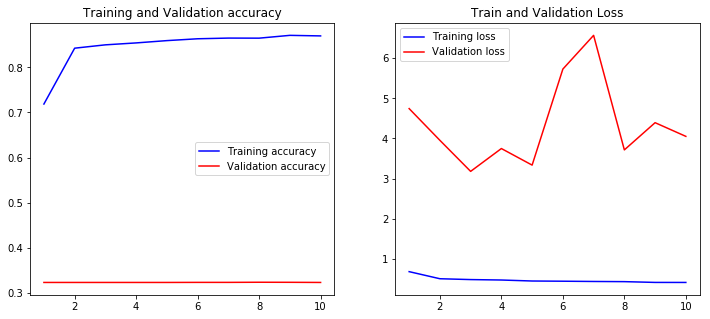

In [34]:
# fit network
batch_size = 128
num_epochs = 10

save_dir = '/Users/mathewlong/Documents/FAIM_Data/NLP'

callbacks=[EarlyStopping(patience=5, monitor='loss', min_delta=0.0001),
           ModelCheckpoint(filepath=save_dir + "/" + 'my_model_twitter_analysis.{epoch:02d}-{val_loss:.2f}.hdf5',\
                           monitor='loss', verbose=0, mode='auto', period=5)]

# fit the model
history = model.fit(X_smote, y_trainRNN, epochs=num_epochs, batch_size=batch_size, validation_data=(X_val_seq, y_valRNN),
                    callbacks=callbacks, verbose=1, shuffle=False)

# save the model
model.save(save_dir + "/" + 'my_model_generate_sentences.h5')

# plot history of training / validation metrics
plot_hist(history)

In [35]:
# process evaluation data for network
evaluate_data = evaluate.values
X_eval = evaluate_data[:,0]
y_eval = evaluate_data[:,1]
y_evalRNN = keras.utils.to_categorical(y_eval, num_classes=3)
# print('y_eval shape', y_eval.shape)
# print('y_evalRNN shape', y_evalRNN.shape)

# apply the same tokenizer from train set on the evaluate set 
sequences = tokenizer.texts_to_sequences(X_eval)
# set vectors to process in the network
X_eval_seq = pad_sequences(sequences, maxlen=40)

# test on evaluation set

prediction = model.predict_classes(X_eval_seq, verbose=1)

y_orig = [np.argmax(y, axis=None, out=None) for y in y_evalRNN]
y_hat = [np.argmax(y, axis=None, out=None) for y in prediction]


lstm_accuracy(y_orig, y_hat)

y_eval shape (69594,)
y_evalRNN shape (69594, 3)
69594/69594 [==============================] - 43s 622us/step


0.8013047101761646

Text(91.68, 0.5, 'predicted label')

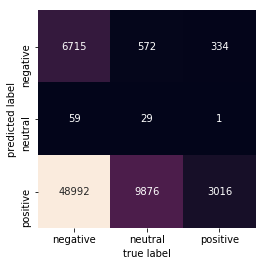

In [21]:
# Plot classification report and confusion matrix 
from sklearn import metrics

# confusion matrix

mat = confusion_matrix(y_orig, prediction)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=['negative','neutral','positive'],
           yticklabels=['negative','neutral','positive'])
plt.xlabel('true label')
plt.ylabel('predicted label')